In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# pd.isnull(df).sum()

## Loading Dataset 

In [2]:
df = pd.read_csv('dataset/train.csv')
df.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
217,218,0,2,"Jacobsohn, Mr. Sidney Samuel",male,42.0,1,0,243847,27.0000,NaN,S
543,544,1,2,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,NaN,S
608,609,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.0,1,2,SC/Paris 2123,41.5792,NaN,C


Creating features:
- family_size 
- title
- is_alone

Dropping features

In [3]:
# create family variable
df['Family_size'] = df['Parch'] + df['SibSp'] + 1
# create title feature
df['Title'] = df['Name'].apply(lambda x : x.split('.')[0].split(',')[1].strip())
df.loc[df['Title'] == 'Mlle','Title'] = 'Miss'
df.loc[df['Title'] == 'Mme', 'Title'] = 'Miss'
df.loc[df['Title'] == 'Ms', 'Title'] = 'Miss'
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Don','Dona', 'Lady', 'the Countess','Capt','Sir', 'Jonkheer']
for r in rare_titles:
    df.loc[df['Title'] == r, 'Title'] = 'Rare Title'

df['IsAlone'] = 0
df.loc[df['Family_size'] == 1, 'IsAlone'] = 1
# remove name, cabin, ticket, 'PassengerId'
df.drop(['Name', 'Cabin', 'Ticket', 'PassengerId', 'Embarked'], axis = 1, inplace = True)
df.sample(3)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family_size,Title,IsAlone
818,0,3,male,43.0,0,0,6.450,1,Mr,1
2,1,3,female,26.0,0,0,7.925,1,Miss,1
405,0,2,male,34.0,1,0,21.000,2,Mr,0


## Reordering Columns

In [4]:
# Reorder columns
['Title', 'Age', 'Sex', 'Pclass', 'IsAlone', 'Family_size', 'SibSp', 'Parch', 'Fare', 'Survived']
new_order = [8, 3, 2, 1, 9, 7, 5, 4, 6, 0]
df = df[df.columns[new_order]]
df.sample(3)

,Title,Age,Sex,Pclass,IsAlone,Family_size,Parch,SibSp,Fare,Survived
312,Mrs,26.0,female,2,0,3,1,1,26.00,0
347,Mrs,NaN,female,3,0,2,0,1,16.10,1
141,Miss,22.0,female,3,1,1,0,0,7.75,1


## Converting character variables to numeric

In [5]:
df['Sex'] = df['Sex'].map( {'male': 0, 'female': 1} ).astype(int) 
df['Title'] = df['Title'].map({'Mr':0, 'Miss':1, 'Mrs':2, 'Master':3, 'Rare Title':4}).astype(int)

In [6]:
df.head(3)

,Title,Age,Sex,Pclass,IsAlone,Family_size,Parch,SibSp,Fare,Survived
0,0,22.0,0,3,0,2,0,1,7.2500,0
1,2,38.0,1,1,0,2,0,1,71.2833,1
2,1,26.0,1,3,1,1,0,0,7.9250,1


## Filling NA values

Age Imputation - Applying linear regression on resulting variables to predict age

In [7]:
print(pd.isnull(df).sum())

Title            0
Age            177
Sex              0
Pclass           0
IsAlone          0
Family_size      0
Parch            0
SibSp            0
Fare             0
Survived         0
dtype: int64


Using Interpolation and linear regression to predict NA values for age feature. I ended up using interpolation.

In [8]:

# train_set = df[pd.isnull(df['Age']),]
train_set = df[df['Age'] >= 0]
X_train = train_set.drop(['Age'], axis = 1)
y_train = train_set.loc[:,'Age']

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# comparing age predictions
age_comparison = df.loc[:,['Age']]
age_comparison['is_null'] = np.where(pd.isnull(age_comparison['Age']), True, False)

age_comparison['Interpolation'] = df.interpolate()['Age']

age_comparison['LR_prediction'] = regressor.predict(df.drop(['Age'], axis = 1))

age_comparison['LR_prediction'] = np.where(age_comparison['is_null'], 
                                           age_comparison['LR_prediction'],
                                           age_comparison['Age'])
                                           
# age_comparison[age_comparison['is_null']]


# # age_comparison['LR_diff'] = age_comparison['Age'] - age_comparison['LR_prediction']
# age_comparison['Interp_diff'] = age_comparison['Age'] - age_comparison['Interpolation']


# mad = age_comparison["LR_diff"].abs().mean()
# std = age_comparison["LR_diff"].abs().std()
# print("Linear Regresssion Prediction")
# print("Mean absolute difference: {}".format(mad))
# print("Standard Deviation: {}".format(std))

# mad = age_comparison["Interp_diff"].abs().mean()
# std = age_comparison["Interp_diff"].abs().std()
# print("Interpolation Prediction")
# print("Mean absolute difference: {}".format(mad))
# print("Standard Deviation: {}".format(std))

df['Age'] = age_comparison['LR_prediction']
df['Age'] = age_comparison['Interpolation']


## Binning Age variable

In [9]:
bins = [0, 2, 12, 18, 25, 54, 65, np.inf]
# labels = ['baby','child','teenager',"young adult",'adult','senior','older person']
labels = [0,1,2,3,4,5,6]
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels)

df.groupby(['Age_Group'])['Age'].mean()

Age_Group
0     1.353519
1     6.955065
2    16.417636
3    22.022707
4    35.937246
5    59.653509
6    71.562500
Name: Age, dtype: float64

In [10]:
new_order = [0,1,10,2,3,4,5,6,7,8,9]
df = df[df.columns[new_order]]
df.sample(5)

,Title,Age,Age_Group,Sex,Pclass,IsAlone,Family_size,Parch,SibSp,Fare,Survived
830,2,15.0,2,1,3,0,2,0,1,14.4542,1
260,0,26.5,4,0,3,1,1,0,0,7.7500,0
196,0,50.0,4,0,3,1,1,0,0,7.7500,0
438,0,64.0,5,0,1,0,6,4,1,263.0000,0
484,0,25.0,3,0,1,0,2,0,1,91.0792,1


## Applying Random Forest

In [11]:
from sklearn.model_selection import train_test_split
X = df.drop(['Survived'], axis = 1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_algorithm(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) # fitting-training the model
    y_pred = model.predict(X_test) # making predictions

    training_accuracy = model.score(X_train, y_train)
    test_accuracy = model.score(X_test, y_test)

    print("Training Accuracy = {:.3f}".format(training_accuracy)) # predicting and scoring on the same time given a the data
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    print(confusion_matrix(y_test, y_pred))
    #     tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    print(classification_report(y_test, y_pred))
    return model

def ta(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train) # fitting-training the model
    test_accuracy = model.score(X_test, y_test)
    return model, test_accuracy

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# print("-"*25,"LOGISTIC REGRESSION","-"*25)
# logreg = LogisticRegression()
# logreg = evaluate_algorithm(logreg, X_train, X_test, y_train, y_test)

# print("-"*25,"SUPPORT VECTOR MACHINES","-"*25)
# svc = SVC()
# svc = evaluate_algorithm(svc, X_train, X_test, y_train, y_test)

print("-"*25,"RANDOM FOREST","-"*25)
rf = RandomForestClassifier(random_state = 1421)
rf = evaluate_algorithm(rf, X_train, X_test, y_train, y_test)
# rf, acc = ta(rf, X_train, X_test, y_train, y_test)
# print(acc)


# print("-"*25,"KNN","-"*25)
# knn = KNeighborsClassifier(n_neighbors = 5)
# knn = evaluate_algorithm(knn, X_train, X_test, y_train, y_test)

# print("-"*25,"NAIVE BAYES CLASSIFIER","-"*25)
# nbc = GaussianNB()
# nbc = evaluate_algorithm(nbc, X_train, X_test, y_train, y_test)

------------------------- RANDOM FOREST -------------------------
Training Accuracy = 0.971
Test Accuracy = 0.847
[[158  17]
 [ 28  92]]
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       175
           1       0.84      0.77      0.80       120

    accuracy                           0.85       295
   macro avg       0.85      0.83      0.84       295
weighted avg       0.85      0.85      0.85       295



## Trying different random states 

In [14]:
from time import time

max_random_state = 2000
start = time()
max_acc = 0
for st in range(max_random_state):
    rf = RandomForestClassifier(random_state = st)
    rf, acc = ta(rf, X_train, X_test, y_train, y_test)
    if acc > max_acc:
        best_rf = rf
        max_acc = acc
        print(f'Random State: {st}')
        print(f'Accuracy: {max_acc}')
finish = round(time()-start,3)
print(f'Program Lasted: {finish} seconds')


Random State: 0
Accuracy: 0.7762711864406779
Random State: 1
Accuracy: 0.7966101694915254
Random State: 2
Accuracy: 0.8033898305084746
Random State: 3
Accuracy: 0.8271186440677966
Random State: 39
Accuracy: 0.8305084745762712
Random State: 124
Accuracy: 0.8372881355932204
Random State: 195
Accuracy: 0.8440677966101695
Random State: 1421
Accuracy: 0.847457627118644
Program Lasted: 34.473 seconds


## Storing Model in a pickle file

In [15]:
import pickle

pickle.dump(best_rf, open('model.pkl','wb'))


## Testing pickle file

In [16]:
import pickle
model = pickle.load(open('model.pkl', 'rb'))
dc = {
    'Title':0,
    'Age':16,
    'Age_Group':2,
    'Sex':0,
    'Pclass':2,
    'IsAlone':1,
    'Family_size':1,
    'Parch':0,
    'SibSp':0,
    'Fare':26,
}
row = [[x for x in dc.values()]]
model.predict_proba(row)[0][0]

0.8

## Random Forest - Plotting Feature Importance

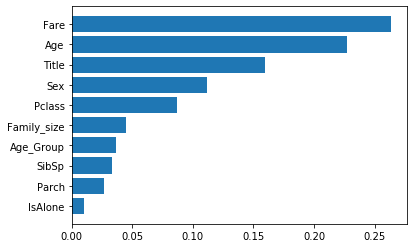

In [18]:
import matplotlib.pyplot as plt

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)

f_importances(best_rf.feature_importances_, list(X_train.columns))